# VectorSum lab for High Performance Computing course
- Python 3.7
- CUDA 11.4
- NVIDIA GeForce GTX 1050 Ti
- Intel Core i5
- Windows 10

## Implementation
В работе для применения технологиии CUDA была исползована библиотека numba. Размерность блоков фиксированная и была установлена значением 16х16.

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, int32
from tabulate import tabulate

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16
# Number of iteration to be done to compute the average elapsed time
ITER_COUNT = 8
# Precision
EPS = 10e-5

Была реализована следующая функция, которая выполняет суммирование элементов вектора на GPU с помощью CUDA. Для ускорения функции была создана область общей памяти для каждого отдельного блока. Производится сначала суммирование элементов в каждом блоке по отдельности, затем эти суммы суммируются в глобальную сумму с помощью атомарной функции.



In [ ]:
@cuda.jit
def gpu_vec_sum(vec, res):
    """
    Calculate the sum of vec elements and save it to res
    """
    shared_buf = cuda.shared.array(TPB, dtype=int32)

    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    idx = tx + bx * TPB

    shared_buf[tx] = 0

    if idx < vec.shape[0]:
      shared_buf[tx] = vec[idx]

      cuda.syncthreads()
      if cuda.threadIdx.x == 0:
          curr_sum = 0
          for i in range(TPB):
              curr_sum += shared_buf[i]
          cuda.atomic.add(res, 0, curr_sum)

Была написана функция main для проведения исследования функции gpu_vec_sum. В цикле на каждой итерации увеличиватеся размер вектора для проведения экспериментов. Для каждого размера считается среднее время выполения gpu_vec_sum вместе с процессом копирования значений переменных с CPU на GPU и обратно, усредненное по ITER_COUNT измерениям. Также вычисляется время работы аналогичной функции, реализованной в библиотеке numpy, для рассчета ускорения. Происходит сравнение результатов, посчитанных этими двумя способами, для проверки корректности gpu_vec_sum. Затем полученные результаты выводятся в виде таблицы и графиков.



In [ ]:
def main():
    rows = []  # rows for the result table
    vec_size_min = 100_000 
    vec_size_max = 1_000_000
    vec_size_interval = 100_000
    for vec_size in range(vec_size_min, vec_size_max + 1, vec_size_interval):
        correct_result = True
        cpu_time_sum = 0.
        gpu_time_sum = 0.
        for _ in range(ITER_COUNT):
            vec = np.random.randint(1000, size=vec_size)
            res = np.zeros(1, dtype=np.int32)

            start = time.time()
            d_vec = cuda.to_device(vec)
            d_res = cuda.to_device(res)
            gpu_vec_sum[int((vec_size + TPB) / TPB), TPB](d_vec, d_res)
            res = d_res.copy_to_host()
            gpu_time_sum += time.time() - start

            start = time.time()
            real_res = np.sum(vec)
            cpu_time = time.time() - start
            cpu_time_sum += cpu_time

            correct_result = np.array_equal(res[0], real_res)
        row = [vec_size, correct_result, cpu_time_sum / ITER_COUNT, gpu_time_sum / ITER_COUNT]
        rows.append(row)
    print(tabulate(rows, headers=['vector size', 'correct result', 'cpu time, ms', 'gpu time, ms']))

    vec_sizes = list(map(lambda x: x[0], rows))
    cpu_times = list(map(lambda x: x[2], rows))
    gpu_times = list(map(lambda x: x[3], rows))
    accelerations = list(map(lambda x: x[2] / (x[3] if x[3] > EPS else EPS), rows))

    plt.figure(figsize=(18,4))

    plt.subplot(1, 3, 1)
    plt.title("cpu time")
    plt.plot(vec_sizes, cpu_times)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("gpu time")
    plt.plot(vec_sizes, gpu_times)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("acceleration")
    plt.plot(vec_sizes, accelerations)
    plt.xlabel("vector size")
    plt.ylabel("cpu to gpu time ratio")
    plt.grid()

    plt.show()

## Results
Были получены слудующие результаты.

  vector size  correct result      cpu time, ms    gpu time, ms
-------------  ----------------  --------------  --------------
       100000  True                 0                0.0612072
       200000  True                 0                0.00110641
       300000  True                 0.000129998      0.00155273
       400000  True                 0.000499696      0.00149709
       500000  True                 0.000249952      0.00162542
       600000  True                 0.000249892      0.0018751
       700000  True                 0.000250369      0.00212571
       800000  True                 0.000249982      0.00237527
       900000  True                 0.000500202      0.00224972
      1000000  True                 0.000749677      0.0025008


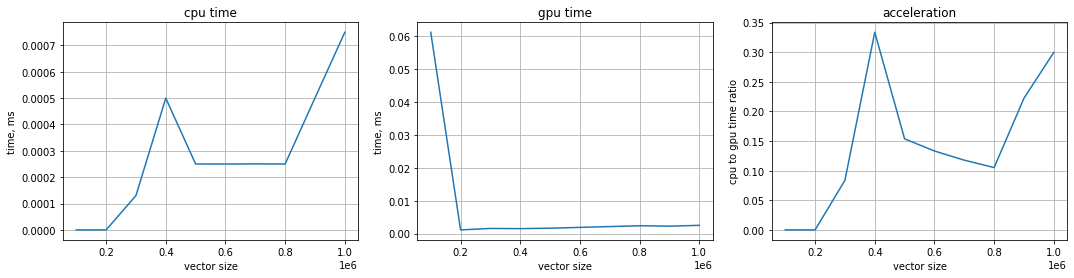

In [ ]:
main()

Из результатов, можно сделать вывод, что реализованная функция суммирования элементов вектора на GPU с помощью CUDA не дает выигрыш по сравнению с аналогичной функцией из numpy. Было сделано предположение, что причина этому заключается в том, что большая часть времени тратится на копирование вектора с CPU на GPU и обратно.

Для проверки этого предположения часть кода в функции main была изменена следующим образом, чтобы считалось время работы функции gpu_vec_sum без операций копирования.

In [ ]:
def main2():
    rows = []  # rows for the result table
    vec_size_min = 100_000 
    vec_size_max = 1_000_000
    vec_size_interval = 100_000
    for vec_size in range(vec_size_min, vec_size_max + 1, vec_size_interval):
        correct_result = True
        cpu_time_sum = 0.
        gpu_time_sum = 0.
        for _ in range(ITER_COUNT):
            vec = np.random.randint(1000, size=vec_size)
            res = np.zeros(1, dtype=np.int32)

            d_vec = cuda.to_device(vec)
            d_res = cuda.to_device(res)
            start = time.time() # now start timer here
            gpu_vec_sum[int((vec_size + TPB) / TPB), TPB](d_vec, d_res)
            gpu_time_sum += time.time() - start # and finish here
            res = d_res.copy_to_host()

            start = time.time()
            real_res = np.sum(vec)
            cpu_time = time.time() - start
            cpu_time_sum += cpu_time

            correct_result = np.array_equal(res[0], real_res)
        row = [vec_size, correct_result, cpu_time_sum / ITER_COUNT, gpu_time_sum / ITER_COUNT]
        rows.append(row)
    print(tabulate(rows, headers=['vector size', 'correct result', 'cpu time, ms', 'gpu time, ms']))

    vec_sizes = list(map(lambda x: x[0], rows))
    cpu_times = list(map(lambda x: x[2], rows))
    gpu_times = list(map(lambda x: x[3], rows))
    accelerations = list(map(lambda x: x[2] / (x[3] if x[3] > EPS else EPS), rows))

    plt.figure(figsize=(18,4))

    plt.subplot(1, 3, 1)
    plt.title("cpu time")
    plt.plot(vec_sizes, cpu_times)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("gpu time")
    plt.plot(vec_sizes, gpu_times)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("acceleration")
    plt.plot(vec_sizes, accelerations)
    plt.xlabel("vector size")
    plt.ylabel("cpu to gpu time ratio")
    plt.grid()

    plt.show()

В результате запуска новой функции main были получены следующие результаты. Теперь функция на GPU дает выигрыш по времени по сравнению с функцией на CPU.



  vector size  correct result      cpu time, ms    gpu time, ms
-------------  ----------------  --------------  --------------
       100000  True                 0.000124902     0.000124782
       200000  True                 0               0.000125051
       300000  True                 0               0.00012514
       400000  True                 0               0.000124872
       500000  True                 0.000128359     0.000253797
       600000  True                 0.000250041     0.000372052
       700000  True                 0.000500917     0.000128478
       800000  True                 0.000626683     0.000120163
       900000  True                 0.000621408     0.000256091
      1000000  True                 0.00137568      0.000374496


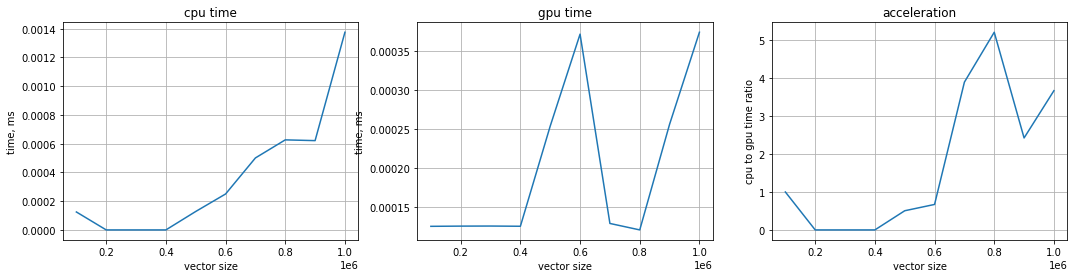

In [ ]:
main2()